In [32]:
import orca
import pandana as pdna
import pandas as pd
import scipy.stats as st
import numpy as np
import os

from urbansim.utils import networks
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep

from urbansim.utils import misc

from difflib import SequenceMatcher

import warnings
warnings.filterwarnings("ignore")

In [33]:
# Set data directory
d = '/home/data/fall_2018/'

if 'data_directory' in orca.list_injectables():
    d = orca.get_injectable('data_directory')
    
# School database 
schools = pd.read_csv('schools.csv')

#CHTS data
@orca.table(cache=True)
def persons():
    df = pd.read_csv(
        d + 'chts_persons_w_zone_ids.csv',
        index_col = ["SAMPN", "PERNO"]
    )
    return df

# Schools standard name transformation 
s_name = pd.read_excel('chts school cleaning.xlsx', 
                       names=['SAMPN', 'PERNO', 'SNAME_lookup_y', 'SNAME',
                                 'SZIP_lookup_y', 'SZIP', 'SCITY_lookup_y', 'SCITY',
                                  'similarity', 'Matched?' ])
# os.listdir("/home/data/CHTS_csv_format/data")

In [75]:
df_person.columns[100:]

Index(['SXST1_persons', 'SXST2_persons', 'SXCORD_persons', 'SYCORD_persons',
       'SMODE', 'EDUCA', 'O_EDUCA', 'INTRV', 'PROXY', 'CMPLG', 'HVLOG',
       'PTRIPS', 'TOLLF', 'TOLLR1', 'TOLLR2', 'TOLLR3', 'TOLLR4', 'TOLLR5',
       'TOLLR6', 'TOLLR7', 'TOLLR8', 'TOLLR9', 'TOLLR10', 'TOLLB1', 'TOLLB2',
       'TOLLB3', 'TOLLB4', 'TOLLB5', 'TOLLB6', 'TOLLB7', 'TOLLB8', 'TOLLB9',
       'TOLLB10', 'HOVL', 'NOGOWHY', 'NOGOWHY_O', 'InComplete', 'Moto_trip',
       'WCTFIP_persons', 'WTRACT_persons', 'SCTFIP_persons', 'STRACT_persons',
       'WPrimaryCity_persons', 'WSTFIP_persons', 'W2PrimaryCity_persons',
       'W2STFIP_persons', 'SPrimaryCity_persons', 'SSTFIP_persons', 'PERWGT',
       'EXPPERWGT', 'WNAME_lookup', 'WCITY_lookup', 'WZIP_lookup',
       'WXST1_lookup', 'WXST2_lookup', 'WXCORD_lookup', 'WYCORD_lookup',
       'WNAME2_lookup', 'WCITY2_lookup', 'WZIP2_lookup', 'WXST2_1_lookup',
       'WXST2_2_lookup', 'SNAME_lookup', 'SCITY_lookup', 'SZIP_lookup',
       'SXST1_lookup', 'S

In [76]:
df_person = persons()
df_person = df_person.reset_index()
df_person['EMPLY'] = [1 if x == 1 else 0 for x in df_person['EMPLY']]
df_person['children'] = [1 if x < 18 else 0 for x in df_person.AGE]
df_person.shape

(24030, 194)

In [78]:
df_person = df_person.groupby(by ='SAMPN').agg({'PERNO': 'count', 'AGE': 'first', 'zone_id_home': 'first', 'EMPLY':'sum', 'children':'sum'})

In [25]:
df_hh = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")
df_hh.shape

(42431, 80)

In [15]:
df_veh.columns

Index(['SAMPN', 'VEHNO', 'YEAR', 'MAKE', 'O_MAKE', 'MODEL', 'SERIES',
       'O_SERIES', 'BODY', 'O_BODY', 'FUELT1', 'FUELT2', 'FUELT3', 'FUELT4',
       'FUELT5', 'FUELT6', 'O_FUELT', 'CIGLT', 'VEHAQ', 'VEHOWN', 'O_VEHOWN',
       'VEHINS', 'VEHOBD', 'VEHTRN', 'VEHDRT', 'O_VEHDRT', 'VEHCYL',
       'O_VEHCYL', 'VEHOUT', 'VEHVLT', 'VEHT', 'CNTV', 'WYCNTV', 'O_WYCNTV',
       'HHWGT', 'EXPHHWGT'],
      dtype='object')

In [105]:
df_veh = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_VEH.csv")
df_veh = df_veh[df_veh.BODY<=8]
df_veh = df_veh.groupby(by='SAMPN').agg({'BODY':'count'})
df_veh.BODY.value_counts()

2    18521
1    13611
3     5707
4     1337
5      266
6       62
7       14
8        7
Name: BODY, dtype: int64

In [137]:
df_merge = df_hh.merge(df_veh, how = 'left', on = 'SAMPN' )
df_merge

,SAMPN,RECMODE,RETMODE,INCEN,ILANG,CTFIP,AREA,STRATA,STYPE,CEC,...,HPFlag,HH_Complete,GPS_Complete,HCTRACT,HPrimaryCity,HSTFIP,MTC_FInalFlag,HHWGT,EXPHHWGT,BODY
0,1031985,1,3,1,1,6095,22,10,1,NaN,...,2,1,1.0,252202,VALLEJO,6,1.0,0.059024,17.295257,2.0
1,1032036,1,1,1,1,6073,28,14,1,NaN,...,2,1,NaN,17030,SAN DIEGO,6,NaN,1.873466,548.964672,1.0
2,1032053,1,1,1,1,6047,19,24,1,NaN,...,1,1,NaN,1602,MERCED,6,NaN,0.055376,16.226415,2.0
3,1032425,1,3,2,1,6083,29,25,1,NaN,...,2,1,NaN,2930,GOLETA,6,NaN,0.024368,7.140418,2.0
4,1032558,1,1,1,2,6037,30,3,1,NaN,...,1,1,NaN,242300,LOS ANGELES,6,NaN,0.153088,44.858108,NaN
5,1033586,1,1,2,1,6061,25,15,1,NaN,...,1,1,NaN,23900,LINCOLN,6,NaN,0.060580,17.751295,2.0
6,1033660,1,3,2,1,6065,30,4,1,NaN,...,2,1,NaN,43403,HEMET,6,NaN,2.059247,603.402543,1.0
7,1033944,1,3,2,1,6075,22,11,1,NaN,...,2,1,NaN,31301,SAN FRANCISCO,6,1.0,0.935391,274.089269,NaN
8,1034462,1,1,1,2,6037,30,3,1,NaN,...,1,1,NaN,232600,LOS ANGELES,6,NaN,1.884779,552.279787,NaN
9,1034878,1,1,2,1,6037,30,3,1,NaN,...,2,1,NaN,702801,CULVER CITY,6,NaN,1.929739,565.453899,1.0


In [138]:
df_merge = df_merge.merge(df_person, how = 'right', on = 'SAMPN' )
df_merge.BODY

0       2.0
1       NaN
2       2.0
3       NaN
4       1.0
5       2.0
6       1.0
7       3.0
8       2.0
9       2.0
10      1.0
11      1.0
12      3.0
13      2.0
14      1.0
15      NaN
16      2.0
17      2.0
18      1.0
19      NaN
20      2.0
21      2.0
22      1.0
23      2.0
24      2.0
25      1.0
26      NaN
27      2.0
28      2.0
29      3.0
       ... 
9689    1.0
9690    2.0
9691    2.0
9692    2.0
9693    1.0
9694    2.0
9695    1.0
9696    1.0
9697    NaN
9698    2.0
9699    1.0
9700    3.0
9701    1.0
9702    1.0
9703    2.0
9704    2.0
9705    4.0
9706    2.0
9707    2.0
9708    2.0
9709    3.0
9710    2.0
9711    2.0
9712    1.0
9713    2.0
9714    2.0
9715    2.0
9716    2.0
9717    3.0
9718    1.0
Name: BODY, Length: 9719, dtype: float64

In [139]:
df_merge = df_merge.loc[:,['BODY','INCOM','AGE','zone_id_home','PERNO','EMPLY','children']]
df_merge = df_merge[df_merge.INCOM<50]
df_merge.BODY = df_merge.BODY.fillna(0)
df_merge['BODY'] = [0 if x==0 else 1 if x == 1 else 2 if x==2 else 3 for x in df_merge['BODY'] ]

In [140]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    return (data - np.mean(data)) / np.std(data)

to_normalize = ['INCOM','AGE','PERNO']

for i in to_normalize:
    df_merge[i] = normalize(df_merge[[i]])


In [141]:
import os; os.chdir('..')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
import glob
warnings.simplefilter('ignore')

import pyproj as proj
from shapely.geometry import MultiPoint
from shapely import geometry

from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

import glob

from scripts import datasources, models, variables

from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
#Splitting the data
x = df_merge.drop('BODY', axis = 1)
y = df_merge.loc[:,'BODY']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

<IPython.core.display.Javascript object>


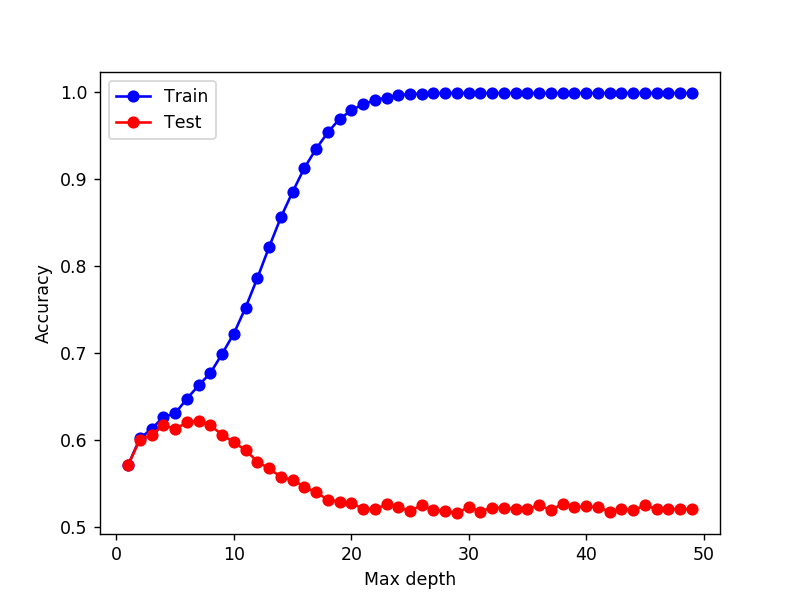

In [143]:
result_train = []
result_test = []
max_depth = range(1,50)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
    
plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

<IPython.core.display.Javascript object>


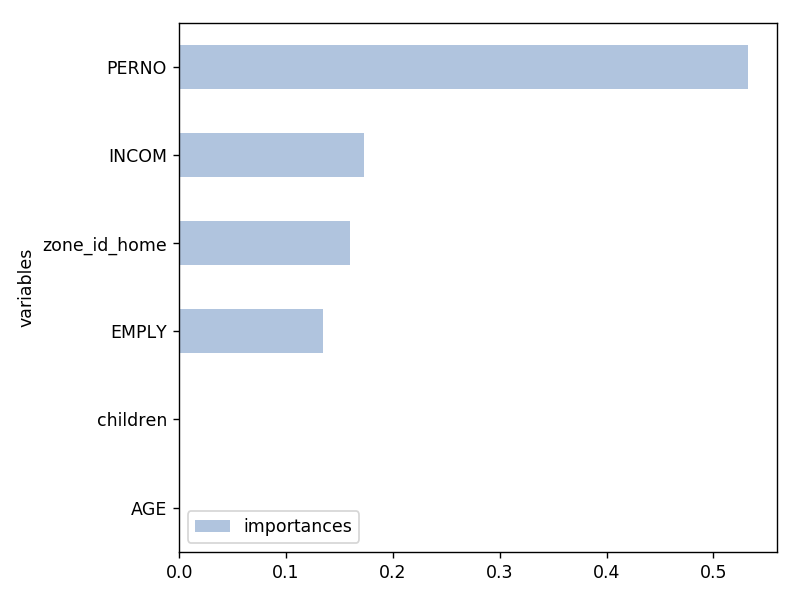

In [144]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4)
clf.fit(X_train, y_train)

aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks()#(fontsize = 10)
plt.tight_layout()

In [145]:
pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

col_0,0,1,2,3
BODY,,,,
0,0.128889,0.724444,0.142222,0.004444
1,0.014317,0.581498,0.398678,0.005507
2,0.000000,0.123053,0.845794,0.031153
3,0.000000,0.040084,0.708861,0.251055


In [146]:
clf.score(X_test, y_test)

0.6094776893808371

In [67]:
df_per = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_PER.csv")
df_per.columns[:100]

Index(['SAMPN', 'PERNO', 'RELAT', 'GEND', 'AGE', 'AGEB', 'HISP', 'RACE1',
       'RACE2', 'RACE3', 'RACE4', 'O_RACE', 'NTVTY', 'CNTRY', 'LIC', 'USER',
       'TRANS', 'TPTYP1', 'TPTYP2', 'TPTYP3', 'TPTYP4', 'TPTYP5', 'TPTYP6',
       'TPTYP7', 'O_TPTYP', 'CLIP1', 'CLIP2', 'CLIP3', 'COMP', 'MET', 'PASSTL',
       'FLEX', 'EMPLY', 'WKSTAT', 'O_WKSTAT', 'JOBS', 'WLOC', 'WNAME', 'WCITY',
       'WSTAT', 'WZIP', 'WXST1', 'WXST2', 'WXCORD', 'WYCORD', 'WDAYS', 'WDAY1',
       'WDAY2', 'WDAY3', 'WDAY4', 'WDAY5', 'WDAY6', 'WDAY7', 'HOURS', 'WSCHED',
       'COMPR', 'WMODE', 'INDUS', 'O_INDUS', 'OCCUP', 'O_OCCUP', 'WLOC2',
       'WNAME2', 'WCITY2', 'WSTAT2', 'WZIP2', 'WXST2_1', 'WXST2_2', 'WDAYS2',
       'DISAB', 'DTYPE1', 'DTYPE2', 'DTYPE3', 'DTYPE4', 'DTYPE5', 'DTYPE6',
       'DTYPE7', 'O_DTYPE', 'DSLIC', 'EDIS', 'TTRIP', 'TRNSUB', 'SUBAMT',
       'SUBUNT', 'O_SUBUNT', 'WTRIP', 'BTRIP', 'STUDE', 'SCHOL', 'O_SCHOL',
       'SLOC', 'SONLN', 'PRESCH', 'O_PRESCH', 'SNAME', 'SCITY', 'SSTAT',
  

In [147]:
os.listdir("/home/data/fall_2018/CHTS_csv_format/data/")

['Deliv_HH.csv',
 'Deliv_ACTIVITY.csv',
 'Deliv_LD.csv',
 'LookUp_LD.csv',
 'LookUp_Home.csv',
 'ASSN_TravelDate.csv',
 'LookUp_PLACE.csv',
 'LookUp_PER.csv',
 'Deliv_PER.csv',
 'Deliv_VEH.csv',
 'Deliv_PLACE.csv']